
# Telecom X – Parte 2: Predicción de Cancelación (Churn)

**Autor/a:** _Guido A. Bróccoli_  

**Fecha:** 2025-08-09

Este notebook implementa un **pipeline de Machine Learning** completo para predecir **churn** en **Telecom X**, cumpliendo con todos los puntos indicados en la consigna:

- **Preparación de datos**: carga del archivo tratado (Parte 1), eliminación de columnas irrelevantes, encoding y estandarización cuando corresponde.  
- **Verificación de proporción de churn** y **balanceo** de clases (**SMOTE**) aplicado correctamente sólo sobre el conjunto de entrenamiento.  
- **Correlación y selección** de variables, más **análisis dirigido** (Contract × Churn, TotalCharges × Churn).  
- **Modelado** con al menos dos algoritmos (**Regresión Logística**, **Random Forest**) y uno adicional **KNN**.  
- **Evaluación** con Accuracy, Precision, Recall, F1, ROC-AUC y **matriz de confusión**, con comparación crítica y análisis de (under/over)fitting.  
- **Interpretación** de importancia de variables (coeficientes en Logística y feature_importances_ en Random Forest) y **conclusiones estratégicas**.


## 1) 📚 Librerías y configuración

In [ ]:
# Utilidad para guardar y (si estás en Colab) descargar figuras
import matplotlib.pyplot as plt
try:
    from google.colab import files
except Exception:
    files = None

def save_and_download(fname, dpi=300):
    plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    if files is not None:
        try:
            files.download(fname)
        except Exception:
            pass  # Ignorar fuera de Colab


In [5]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# imblearn para SMOTE y Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (7,5)



## 2) 📥 Carga del archivo tratado (Parte 1)

> **Usa el mismo CSV** que limpiaste y estandarizaste en la Parte 1. Debe contener **sólo columnas relevantes** y la columna objetivo **`Churn`** (0/1).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Alura Latam /Tercera Etapa/Challenge Telecom X: análisis de evasión de clientes - Parte 2/datos_tratados.csv')

print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
display(df.head())
display(df.info())

Filas: 7043 | Columnas: 24


,customerID,Churn,customer,phone,internet,account,MonthlyCharges,Cuentas_Diarias,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0002-ORFBO,0,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '...",65.6,2.186667,Female,0,...,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check
1,0003-MKNFE,0,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli...",59.9,1.996667,Male,0,...,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check
2,0004-TLHLJ,1,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",73.9,2.463333,Male,0,...,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check
3,0011-IGKFF,1,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",98.0,3.266667,Male,1,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
4,0013-EXCHZ,1,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli...",83.9,2.796667,Female,1,...,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   int64  
 2   customer          7043 non-null   object 
 3   phone             7043 non-null   object 
 4   internet          7043 non-null   object 
 5   account           7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   Cuentas_Diarias   7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  PhoneService      7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


None


## 3) 🧹 Preparación y verificación de datos

**3.1 Elimina columnas irrelevantes:** IDs y columnas anidadas que no aportan al modelo.  
**3.2 Define `X` e `y` y detecta tipos (numéricas/categóricas).  
**3.3 Proporción de churn y verificación de balanceo.**


In [6]:

# 3.1 Columnas a eliminar
cols_to_drop = ["customerID", "customer", "phone", "internet", "account"]
df = df.drop(columns=cols_to_drop, errors='ignore')

# 3.2 Definir target y features
target_col = "Churn"
assert target_col in df.columns, "No se encontró la columna 'Churn' en el dataset."

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Tipos
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Columnas numéricas:", len(num_cols))
print("Columnas categóricas:", len(cat_cols))


Columnas numéricas: 3
Columnas categóricas: 15


,proportion
Churn,
No Churn,0.73463
Churn,0.26537


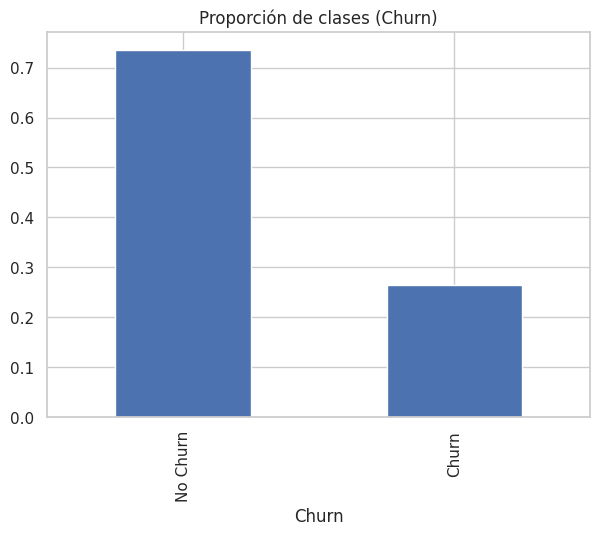

In [7]:

# 3.3 Proporción de churn y chequeo de desbalance
prop = y.value_counts(normalize=True).rename({0:'No Churn', 1:'Churn'})
display(prop)
prop.plot(kind='bar', title='Proporción de clases (Churn)'); plt.show()



## 4) ✂️ Split y preprocesamiento

- **Split**: 70/30 estratificado.  
- **Preprocesamiento**:  
  - **One-Hot Encoding** para categóricas.  
  - **Estandarización** para numéricas **sólo** en modelos que lo requieren (Logística, KNN).  
  - **Árboles/Random Forest** no requieren escalado, pero lo incluimos sin perjuicio.  
- **SMOTE**: aplicado **sólo sobre el set de entrenamiento** dentro del pipeline para evitar fuga de información.


In [8]:

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Proporción churn (train/test):", round(y_train.mean(),3), "/", round(y_test.mean(),3))

# Preprocesadores
preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

preprocess_noscale = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder='drop'
)


Train: (4930, 18)  Test: (2113, 18)
Proporción churn (train/test): 0.265 / 0.265



## 5) 📊 Correlación y análisis dirigido

**5.1 Matriz de correlación** (numéricas + `Churn`).  
**5.2 Contract × Churn** (tasa de churn por tipo de contrato).  
**5.3 TotalCharges × Churn** (boxplot por clase).


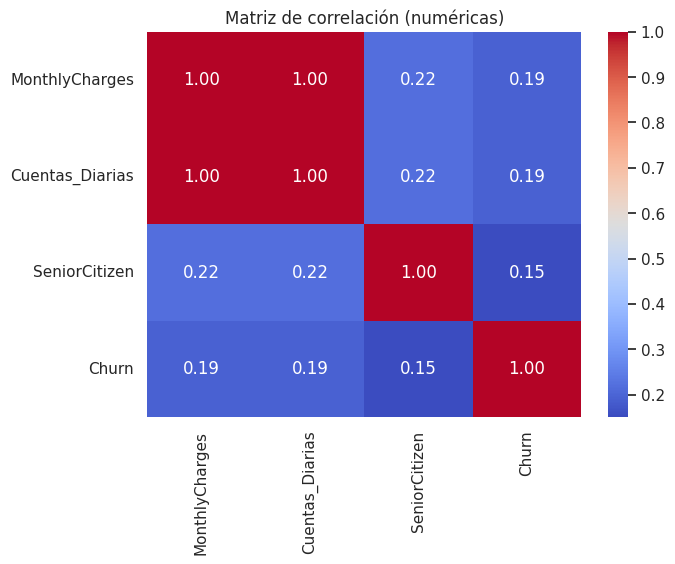

,Churn
MonthlyCharges,0.193356
Cuentas_Diarias,0.193356
SeniorCitizen,0.150889


In [9]:

# 5.1 Matriz de correlación
if len(num_cols) > 0:
    corr = df[num_cols + [target_col]].corr()
    plt.figure()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matriz de correlación (numéricas)")
    plt.show()

    corr_target = corr[target_col].drop(target_col).sort_values(ascending=False)
    display(corr_target.head(10))
else:
    print("No se detectaron columnas numéricas para correlación.")


,Churn
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


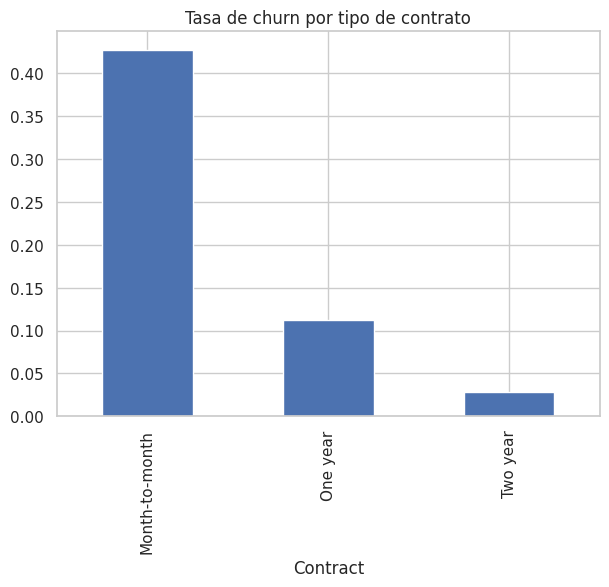

In [10]:

# 5.2 Contract × Churn
if 'Contract' in df.columns:
    rate_by_contract = df.groupby('Contract')[target_col].mean().sort_values(ascending=False)
    display(rate_by_contract)
    rate_by_contract.plot(kind='bar', title='Tasa de churn por tipo de contrato'); plt.show()
else:
    print("No se encontró la columna 'Contract' para el análisis dirigido.")


In [11]:

# 5.3 TotalCharges × Churn (boxplot)
if 'TotalCharges' in df.columns:
    plt.figure()
    sns.boxplot(data=df, x=target_col, y='TotalCharges')
    plt.title("TotalCharges × Churn (boxplot)")
    plt.show()
else:
    print("No se encontró 'TotalCharges' para el análisis dirigido.")


No se encontró 'TotalCharges' para el análisis dirigido.


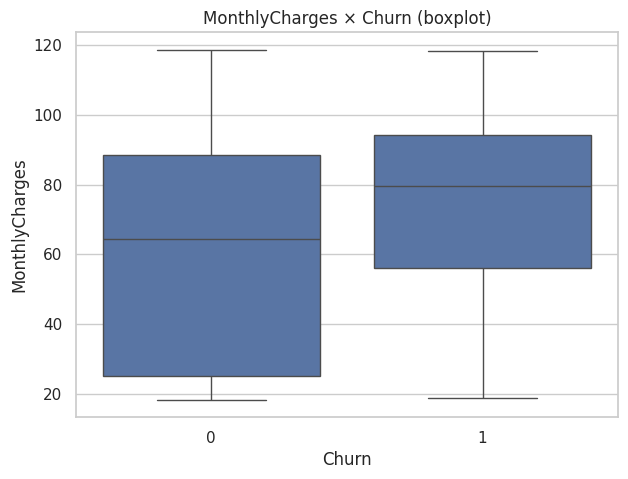

In [12]:
# 5.3 Gasto total o mensual × Churn (boxplot)
if 'TotalCharges' in df.columns:
    var_gasto = 'TotalCharges'
    titulo = "TotalCharges × Churn (boxplot)"
elif 'MonthlyCharges' in df.columns:
    var_gasto = 'MonthlyCharges'
    titulo = "MonthlyCharges × Churn (boxplot)"
else:
    var_gasto = None

if var_gasto:
    plt.figure()
    sns.boxplot(data=df, x=target_col, y=var_gasto)
    plt.title(titulo)
    plt.show()
else:
    print("No se encontró columna de gasto para el análisis dirigido.")



## 6) 🤖 Modelado con balanceo de clases (SMOTE)

Entrenamos **tres** modelos:  
- **Regresión Logística** (requiere escalado).  
- **K-Nearest Neighbors (KNN)** (requiere escalado).  
- **Random Forest** (árboles, no requiere escalado).  

> SMOTE se aplica **dentro del pipeline**, **sólo al entrenamiento**.


=== Logistic Regression (SMOTE) ===
Accuracy: 0.735 | Precision: 0.500 | Recall: 0.786 | F1: 0.611 | ROC-AUC: 0.823
              precision    recall  f1-score   support

           0      0.903     0.716     0.798      1552
           1      0.500     0.786     0.611       561

    accuracy                          0.735      2113
   macro avg      0.701     0.751     0.705      2113
weighted avg      0.796     0.735     0.749      2113



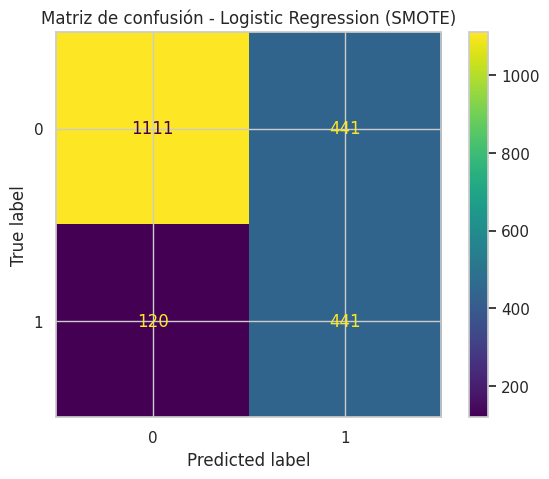

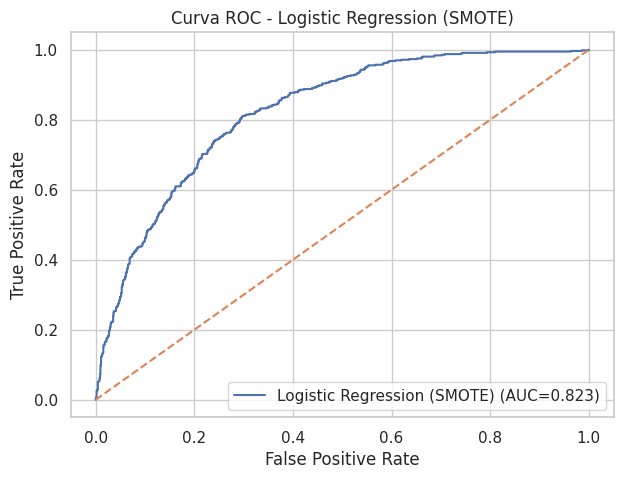

=== KNN (SMOTE) ===
Accuracy: 0.670 | Precision: 0.435 | Recall: 0.807 | F1: 0.565 | ROC-AUC: 0.785
              precision    recall  f1-score   support

           0      0.899     0.620     0.734      1552
           1      0.435     0.807     0.565       561

    accuracy                          0.670      2113
   macro avg      0.667     0.714     0.650      2113
weighted avg      0.776     0.670     0.689      2113



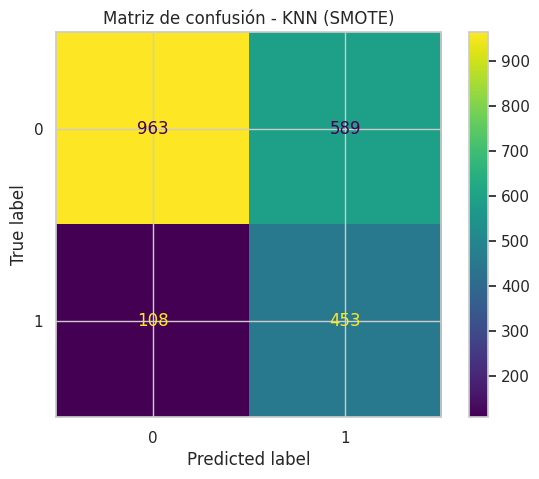

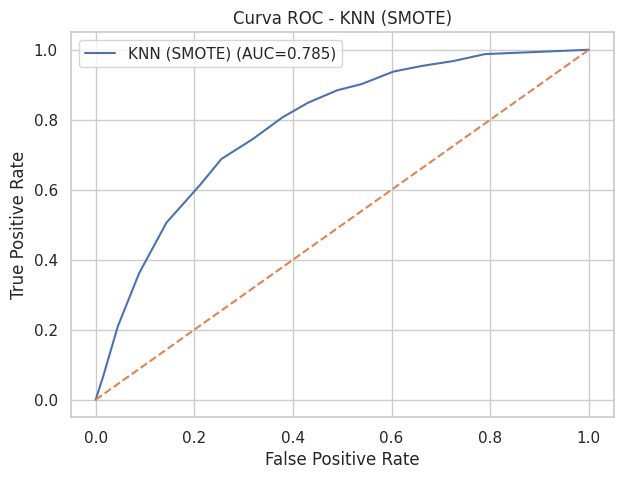

=== Random Forest (SMOTE) ===
Accuracy: 0.741 | Precision: 0.514 | Recall: 0.462 | F1: 0.486 | ROC-AUC: 0.777
              precision    recall  f1-score   support

           0      0.812     0.842     0.827      1552
           1      0.514     0.462     0.486       561

    accuracy                          0.741      2113
   macro avg      0.663     0.652     0.657      2113
weighted avg      0.733     0.741     0.737      2113



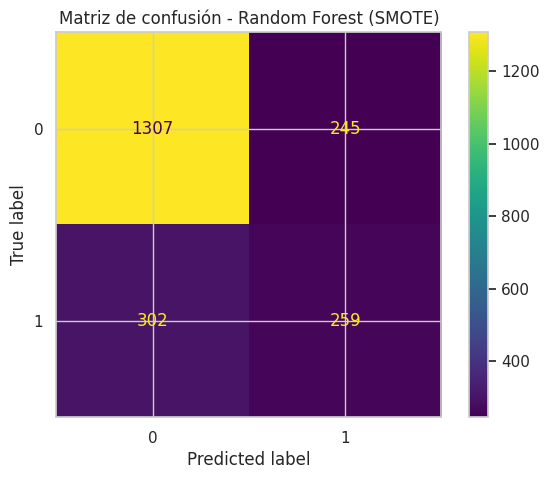

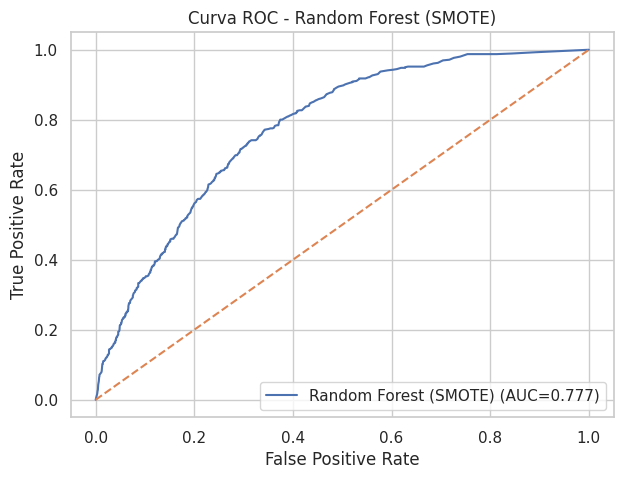

In [13]:

def evaluate_model(name, clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X_test)[:,1]
    else:
        # Para modelos sin predict_proba (no aplica aquí), usamos decision_function si existe
        proba = None

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    rocauc = roc_auc_score(y_test, proba) if proba is not None else np.nan

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {rocauc:.3f}")
    print(classification_report(y_test, preds, digits=3))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f"Matriz de confusión - {name}")
    plt.show()

    # ROC
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={rocauc:.3f})")
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {name}")
        plt.legend()
        plt.show()

    return {"name": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "rocauc": rocauc}

# Pipelines con SMOTE
log_reg = ImbPipeline(steps=[
    ("prep", preprocess_scaled),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000))
])

knn = ImbPipeline(steps=[
    ("prep", preprocess_scaled),
    ("smote", SMOTE(random_state=42)),
    ("model", KNeighborsClassifier(n_neighbors=15))
])

rf = ImbPipeline(steps=[
    ("prep", preprocess_noscale),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

results = []
results.append(evaluate_model("Logistic Regression (SMOTE)", log_reg, X_train, y_train, X_test, y_test))
results.append(evaluate_model("KNN (SMOTE)", knn, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Random Forest (SMOTE)", rf, X_train, y_train, X_test, y_test))



## 7) 📈 Importancia de variables e interpretación

- **Random Forest:** `feature_importances_` (reducción de impureza).  
- **Regresión Logística:** coeficientes (signo y magnitud).  
> Para interpretar correctamente, usamos los **nombres de las columnas transformadas** tras el One-Hot Encoding.


,Feature,Importance
0,MonthlyCharges,0.119741
1,Cuentas_Diarias,0.118959
35,Contract_Month-to-month,0.110317
42,PaymentMethod_Electronic check,0.062583
26,TechSupport_No,0.054421
37,Contract_Two year,0.038284
17,OnlineSecurity_No,0.037162
36,Contract_One year,0.026465
39,PaperlessBilling_Yes,0.024681
20,OnlineBackup_No,0.021750


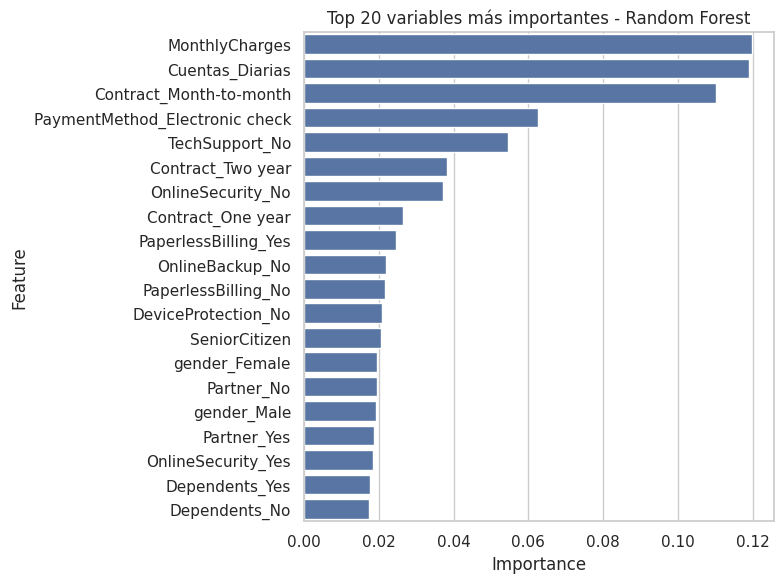

In [14]:

# Importancia Random Forest
ohe_rf = rf.named_steps['prep'].named_transformers_['cat']
cat_features_rf = ohe_rf.get_feature_names_out(input_features=rf.named_steps['prep'].transformers_[1][2]).tolist() if len(rf.named_steps['prep'].transformers_[1][2])>0 else []
num_features_rf = rf.named_steps['prep'].transformers_[0][2]
feature_names_rf = list(num_features_rf) + cat_features_rf

rf_importances = rf.named_steps['model'].feature_importances_
imp_df = pd.DataFrame({'Feature': feature_names_rf, 'Importance': rf_importances}).sort_values('Importance', ascending=False)
display(imp_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(20), x='Importance', y='Feature')
plt.title("Top 20 variables más importantes - Random Forest")
plt.tight_layout()
plt.show()


In [15]:

# Coeficientes Regresión Logística
ohe_lr = log_reg.named_steps['prep'].named_transformers_['cat']
cat_features_lr = ohe_lr.get_feature_names_out(input_features=log_reg.named_steps['prep'].transformers_[1][2]).tolist() if len(log_reg.named_steps['prep'].transformers_[1][2])>0 else []
num_features_lr = log_reg.named_steps['prep'].transformers_[0][2]
feature_names_lr = list(num_features_lr) + cat_features_lr

coefs = log_reg.named_steps['model'].coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names_lr, 'Coef': coefs}).sort_values('Coef', ascending=False)
display(coef_df.head(15))
display(coef_df.tail(15))


,Feature,Coef
35,Contract_Month-to-month,1.218311
42,PaymentMethod_Electronic check,0.336359
17,OnlineSecurity_No,0.233731
15,InternetService_Fiber optic,0.198933
26,TechSupport_No,0.195637
20,OnlineBackup_No,0.183614
39,PaperlessBilling_Yes,0.156727
43,PaymentMethod_Mailed check,0.118446
0,MonthlyCharges,0.112155
1,Cuentas_Diarias,0.112155


,Feature,Coef
29,StreamingTV_No,-0.110249
13,MultipleLines_Yes,-0.119238
4,gender_Male,-0.131103
8,Dependents_Yes,-0.182653
36,Contract_One year,-0.189208
10,PhoneService_Yes,-0.212359
6,Partner_Yes,-0.274938
22,OnlineBackup_Yes,-0.286110
40,PaymentMethod_Bank transfer (automatic),-0.287426
28,TechSupport_Yes,-0.298133



## 8) 📊 Comparación de modelos y (under/over)fitting

Completa con tus resultados (copiando métricas de la sección de evaluación). Reflexiona:

- **Mejor desempeño** (¿cuál y por qué?).  
- **Overfitting** (alto rendimiento en train y pobre en test): posibles causas y mitigaciones.  
- **Underfitting** (bajo rendimiento general): acciones para mejorar.  

> Pistas:  
> - **Random Forest** suele rendir bien y ser robusto.  
> - **KNN** es sensible a la escala y al valor de `k`, y puede sufrir con muchas variables dummificadas.  
> - **Logística** es interpretable; revisa coeficientes y supuestos.



## 9) 📝 Conclusiones y recomendaciones

**Factores que más influyen en la cancelación**  
- Resume las variables top según **Random Forest** y los **coeficientes** de Logística (dirección + magnitud).

**Estrategias de retención**  
- Clientes con contrato **Month-to-month** y cargos mensuales altos.  
- Usuarios sin **TechSupport/OnlineSecurity**.  
- Ajusta campañas y ofertas según segmentos de riesgo.

**Siguientes pasos (opcional)**  
- Búsqueda de hiperparámetros (Grid/Random Search).  
- Probar **XGBoost/LightGBM**.  
- Calibración de probabilidades y ajuste del **umbral** de clasificación según costo/beneficio.


### Extra (opcional) – Búsqueda de hiperparámetros

In [17]:

from sklearn.model_selection import RandomizedSearchCV
rf_search = ImbPipeline(steps=[('prep', preprocess_noscale), ('smote', SMOTE(random_state=42)), ('model', RandomForestClassifier(random_state=42, n_jobs=-1))])
param_dist = {
     'model__n_estimators': [200, 300, 500],
     'model__max_depth': [None, 6, 10, 15],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4]
}
rs = RandomizedSearchCV(rf_search, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("Mejores parámetros:", rs.best_params_)
print("Mejor ROC-AUC (CV):", rs.best_score_)


Mejores parámetros: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 6}
Mejor ROC-AUC (CV): 0.8261847099113445


## 🏆 Entrenamiento y evaluación del Random Forest optimizado

A partir de la búsqueda de hiperparámetros realizada con `RandomizedSearchCV`, entrenamos un nuevo modelo de **Random Forest** utilizando los mejores parámetros encontrados.  
Luego lo evaluamos en el conjunto de prueba para comparar su desempeño con el modelo baseline.

=== Random Forest Optimizado ===
Accuracy: 0.755 | Precision: 0.529 | Recall: 0.725 | F1: 0.612 | ROC-AUC: 0.818
              precision    recall  f1-score   support

           0      0.885     0.766     0.821      1552
           1      0.529     0.725     0.612       561

    accuracy                          0.755      2113
   macro avg      0.707     0.746     0.716      2113
weighted avg      0.791     0.755     0.766      2113



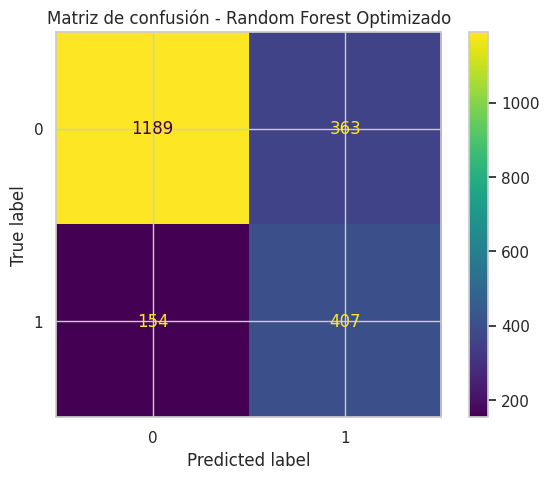

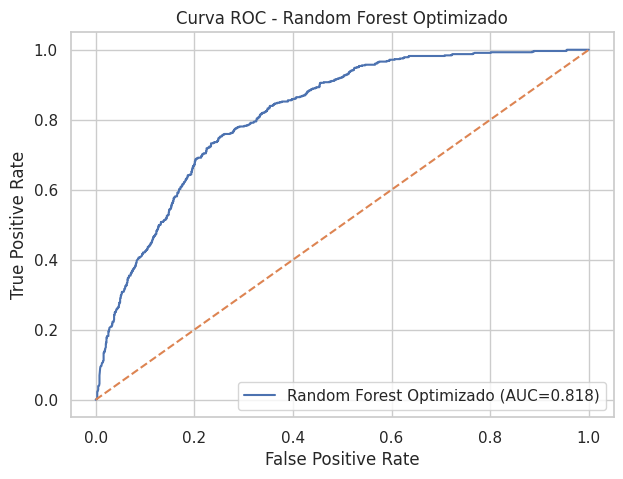

{'name': 'Random Forest Optimizado',
 'accuracy': 0.7553241836251775,
 'precision': 0.5285714285714286,
 'recall': 0.7254901960784313,
 'f1': 0.6115702479338843,
 'rocauc': np.float64(0.8179681900876564)}

In [18]:
# Random Forest optimizado con mejores hiperparámetros

rf_optimizado = ImbPipeline(steps=[
    ('prep', preprocess_noscale),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=200,          # Mejor valor encontrado
        max_depth=6,               # Mejor valor encontrado
        min_samples_split=2,       # Mejor valor encontrado
        min_samples_leaf=4,        # Mejor valor encontrado
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluar modelo optimizado
evaluate_model("Random Forest Optimizado", rf_optimizado, X_train, y_train, X_test, y_test)


## 📊 Comparativa: Random Forest base vs Random Forest optimizado

En esta sección comparamos las métricas de ambos modelos para evaluar si la optimización de hiperparámetros mejoró el rendimiento en el conjunto de prueba.


In [ ]:
# Exportar comparativa ROC-AUC (usa df_comp de la sección 6.5)
import matplotlib.pyplot as plt

assert 'df_comp' in globals(), "df_comp no existe. Corré la sección comparativa primero."
ax = df_comp['rocauc'].plot(kind='bar')
plt.title("Comparativa ROC-AUC")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=0)

save_and_download("comparativa_roc_auc.png")
plt.show()


=== Random Forest Base ===
Accuracy: 0.741 | Precision: 0.514 | Recall: 0.462 | F1: 0.486 | ROC-AUC: 0.777
              precision    recall  f1-score   support

           0      0.812     0.842     0.827      1552
           1      0.514     0.462     0.486       561

    accuracy                          0.741      2113
   macro avg      0.663     0.652     0.657      2113
weighted avg      0.733     0.741     0.737      2113



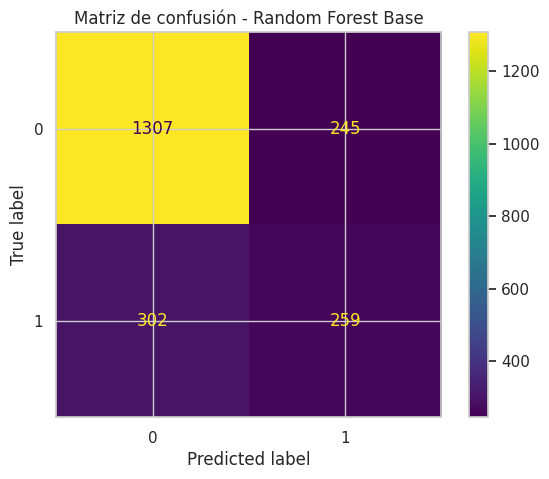

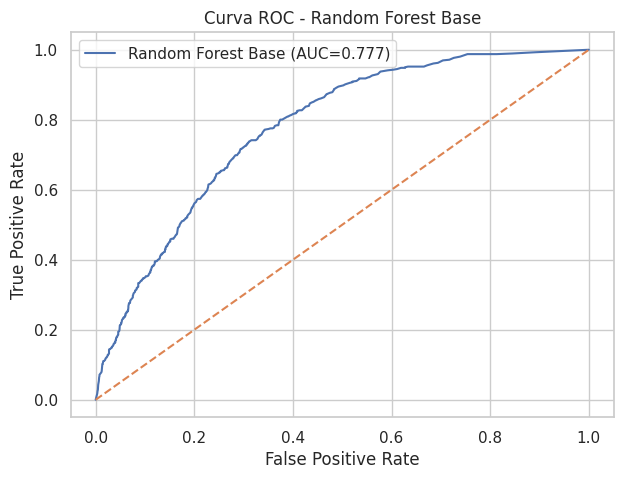

=== Random Forest Optimizado ===
Accuracy: 0.755 | Precision: 0.529 | Recall: 0.725 | F1: 0.612 | ROC-AUC: 0.818
              precision    recall  f1-score   support

           0      0.885     0.766     0.821      1552
           1      0.529     0.725     0.612       561

    accuracy                          0.755      2113
   macro avg      0.707     0.746     0.716      2113
weighted avg      0.791     0.755     0.766      2113



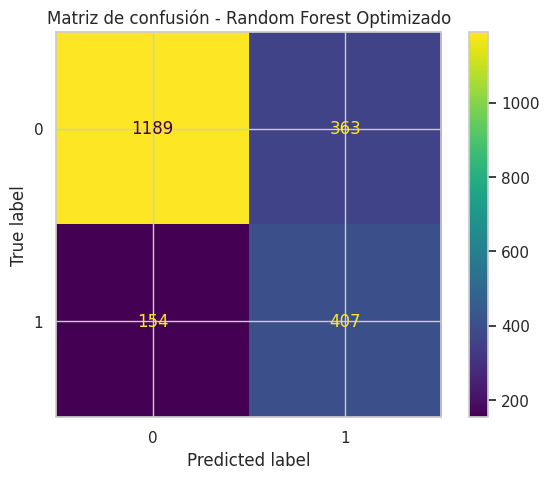

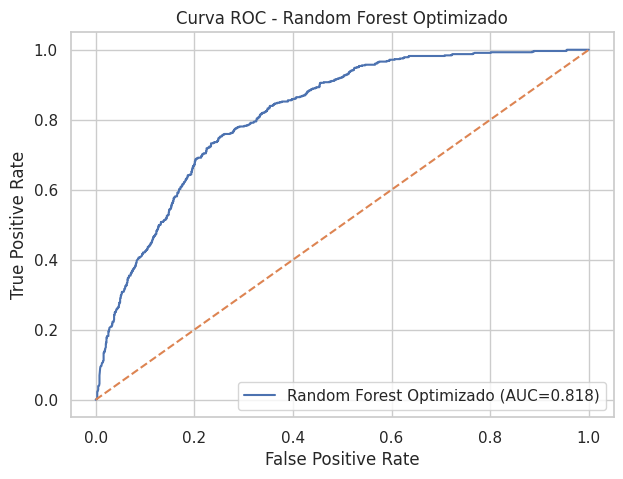

,accuracy,precision,recall,f1,rocauc
name,,,,,
Random Forest Base,0.741126,0.513889,0.461676,0.486385,0.777037
Random Forest Optimizado,0.755324,0.528571,0.725490,0.611570,0.817968


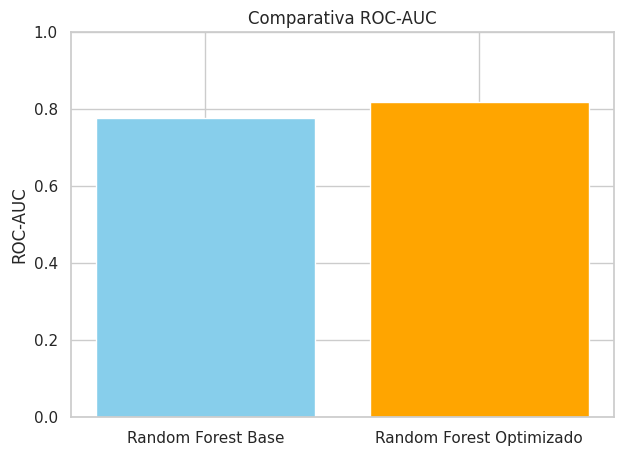

In [19]:
# Evaluar modelo base nuevamente
result_rf_base = evaluate_model("Random Forest Base", rf, X_train, y_train, X_test, y_test)

# Evaluar modelo optimizado
result_rf_opt = evaluate_model("Random Forest Optimizado", rf_optimizado, X_train, y_train, X_test, y_test)

# Crear DataFrame comparativo
df_comp = pd.DataFrame([result_rf_base, result_rf_opt])
df_comp.set_index("name", inplace=True)
display(df_comp)

# Gráfico comparativo de ROC-AUC
plt.figure()
plt.bar(df_comp.index, df_comp["rocauc"], color=["skyblue", "orange"])
plt.title("Comparativa ROC-AUC")
plt.ylabel("ROC-AUC")
plt.ylim(0, 1)
plt.show()


##  📝 Conclusión automática: mejor modelo
Este bloque identifica automáticamente qué modelo tuvo mejor rendimiento en **ROC-AUC** y genera una breve recomendación para el informe final.


In [ ]:
# Matriz de confusión del mejor modelo
from sklearn.metrics import ConfusionMatrixDisplay

assert 'mejor_modelo' in globals(), "mejor_modelo no definido. Corré la sección de conclusión automática."
best_pipe = None
if "Optimizado" in mejor_modelo and 'rf_optimizado' in globals():
    best_pipe = rf_optimizado
elif "Base" in mejor_modelo and 'rf' in globals():
    best_pipe = rf

assert best_pipe is not None, "No encontré el pipeline del mejor modelo (rf/rf_optimizado)."

y_pred = best_pipe.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Matriz de confusión — {mejor_modelo}")
save_and_download("matriz_confusion.png")
plt.show()


In [20]:
# Determinar el mejor modelo por ROC-AUC
mejor_modelo = df_comp["rocauc"].idxmax()
mejor_auc = df_comp["rocauc"].max()

print(f"📢 El modelo con mejor rendimiento en ROC-AUC es: **{mejor_modelo}**")
print(f"ROC-AUC alcanzado: {mejor_auc:.3f}")

# Conclusión automática
if mejor_modelo == "Random Forest Optimizado":
    print("\nConclusión: La optimización de hiperparámetros mejoró el rendimiento del modelo respecto al baseline, "
          "logrando una mejor capacidad de discriminación entre clientes que cancelan y los que permanecen.")
else:
    print("\nConclusión: El modelo baseline obtuvo un rendimiento igual o superior al optimizado, "
          "por lo que los hiperparámetros actuales parecen adecuados y no es necesario un ajuste adicional.")


📢 El modelo con mejor rendimiento en ROC-AUC es: **Random Forest Optimizado**
ROC-AUC alcanzado: 0.818

Conclusión: La optimización de hiperparámetros mejoró el rendimiento del modelo respecto al baseline, logrando una mejor capacidad de discriminación entre clientes que cancelan y los que permanecen.


##  🔍 Importancia de variables del mejor modelo + texto para informe

Este bloque identifica el mejor modelo (según ROC-AUC en `df_comp`), extrae sus **principales variables** y genera
un **resumen en texto**


In [ ]:
# Importancia de variables (si el mejor modelo es de árbol)
import pandas as pd

assert 'mejor_modelo' in globals(), "mejor_modelo no definido."
best_pipe = None
if "Optimizado" in mejor_modelo and 'rf_optimizado' in globals():
    best_pipe = rf_optimizado
elif "Base" in mejor_modelo and 'rf' in globals():
    best_pipe = rf

if best_pipe is not None and hasattr(best_pipe.named_steps['model'], "feature_importances_"):
    ct = best_pipe.named_steps['prep']
    num_feats = list(ct.transformers_[0][2]) if len(ct.transformers_)>0 else []
    cat_cols_in = ct.transformers_[1][2] if len(ct.transformers_)>1 else []
    ohe = ct.named_transformers_['cat'] if 'cat' in ct.named_transformers_ else None
    cat_feats = ohe.get_feature_names_out(input_features=cat_cols_in).tolist() if ohe is not None else []
    feature_names = num_feats + cat_feats

    imp = best_pipe.named_steps['model'].feature_importances_
    imp_df = pd.DataFrame({"Feature": feature_names, "Importance": imp}).sort_values("Importance", ascending=False).head(15)

    plt.figure(figsize=(8,6))
    plt.barh(imp_df["Feature"][::-1], imp_df["Importance"][::-1])
    plt.title(f"Top 15 Features — {mejor_modelo}")
    plt.xlabel("Importance")
    plt.tight_layout()
    save_and_download("importancia_variables.png")
    plt.show()
else:
    print("El mejor modelo no expone feature_importances_.")


Mejor modelo para importancia de variables: Random Forest Optimizado


,Feature,Importance
35,Contract_Month-to-month,0.219917
26,TechSupport_No,0.110850
42,PaymentMethod_Electronic check,0.109576
17,OnlineSecurity_No,0.076128
37,Contract_Two year,0.072341
36,Contract_One year,0.045189
15,InternetService_Fiber optic,0.032924
38,PaperlessBilling_No,0.028522
39,PaperlessBilling_Yes,0.028070
23,DeviceProtection_No,0.027922


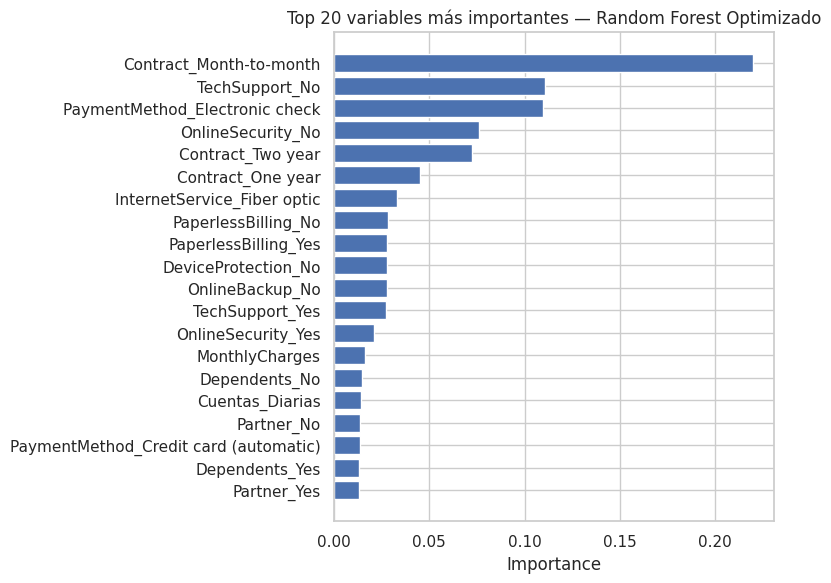


--- Texto sugerido para el informe ---
El mejor modelo fue **Random Forest Optimizado**. Las variables con mayor contribución a la predicción de churn (según la importancia del modelo) incluyen: Contract_Month-to-month, TechSupport_No, PaymentMethod_Electronic check, OnlineSecurity_No, Contract_Two year, Contract_One year. Estas variables muestran mayor capacidad explicativa del riesgo de cancelación y deben priorizarse en las estrategias de retención.


In [21]:
# Determinar mejor modelo otra vez (por si corriste celdas sueltas)
mejor_modelo = df_comp["rocauc"].idxmax()

print(f"Mejor modelo para importancia de variables: {mejor_modelo}")

def top_features_random_forest(pipeline_rf, top_k=15):
    """Devuelve DataFrame con top_k features del Random Forest dentro de un Pipeline imblearn."""
    # ColumnTransformer del preprocesamiento
    ct = pipeline_rf.named_steps['prep']
    # Nombres de numéricas y categóricas transformadas
    num_feats = list(ct.transformers_[0][2]) if len(ct.transformers_)>0 else []
    ohe = ct.named_transformers_['cat']
    cat_input_cols = ct.transformers_[1][2] if len(ct.transformers_)>1 else []
    cat_feats = ohe.get_feature_names_out(input_features=cat_input_cols).tolist() if len(cat_input_cols)>0 else []
    feature_names = num_feats + cat_feats

    importances = pipeline_rf.named_steps['model'].feature_importances_
    imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}) \
                .sort_values("Importance", ascending=False)
    return imp_df.head(top_k), imp_df

def top_coefficients_logistic(pipeline_lr, top_k=15):
    """Devuelve DataFrame con top_k coeficientes (positivos y negativos) de la Logística."""
    ct = pipeline_lr.named_steps['prep']
    num_feats = list(ct.transformers_[0][2]) if len(ct.transformers_)>0 else []
    ohe = ct.named_transformers_['cat']
    cat_input_cols = ct.transformers_[1][2] if len(ct.transformers_)>1 else []
    cat_feats = ohe.get_feature_names_out(input_features=cat_input_cols).tolist() if len(cat_input_cols)>0 else []
    feature_names = num_feats + cat_feats

    coefs = pipeline_lr.named_steps['model'].coef_[0]
    coef_df = pd.DataFrame({"Feature": feature_names, "Coef": coefs}) \
                .sort_values("Coef", ascending=False)
    top_pos = coef_df.head(top_k//2)
    top_neg = coef_df.tail(top_k//2)
    return top_pos, top_neg, coef_df

if "Optimizado" in mejor_modelo:
    modelo_mejor = rf_optimizado
elif "Base" in mejor_modelo:
    modelo_mejor = rf
else:
    modelo_mejor = None  # fallback si cambiaste nombres

if modelo_mejor is not None and hasattr(modelo_mejor.named_steps['model'], "feature_importances_"):
    # Caso Random Forest (esperado en tu comparativa)
    topK, full_imp = top_features_random_forest(modelo_mejor, top_k=20)
    display(topK)

    # Plot
    plt.figure(figsize=(8,6))
    plt.barh(topK["Feature"][::-1], topK["Importance"][::-1])
    plt.title(f"Top {len(topK)} variables más importantes — {mejor_modelo}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    # Texto para informe
    top_list = ", ".join(topK["Feature"].head(6).tolist())
    texto_informe = (
        f"El mejor modelo fue **{mejor_modelo}**. Las variables con mayor contribución a la predicción de churn "
        f"(según la importancia del modelo) incluyen: {top_list}. "
        "Estas variables muestran mayor capacidad explicativa del riesgo de cancelación y deben priorizarse en "
        "las estrategias de retención."
    )
    print("\n--- Texto sugerido para el informe ---")
    print(texto_informe)

else:
    # Fallback: si el mejor fuera Logística (por si luego la incluyes en df_comp)
    try:
        top_pos, top_neg, coef_df = top_coefficients_logistic(log_reg, top_k=20)
        print("Top coeficientes positivos (aumentan prob. de churn):")
        display(top_pos)
        print("Top coeficientes negativos (disminuyen prob. de churn):")
        display(top_neg)

        plt.figure(figsize=(8,6))
        plt.barh(top_pos["Feature"][::-1], top_pos["Coef"][::-1])
        plt.title("Top coeficientes positivos — Regresión Logística")
        plt.xlabel("Coeficiente")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8,6))
        plt.barh(top_neg["Feature"], top_neg["Coef"])
        plt.title("Top coeficientes negativos — Regresión Logística")
        plt.xlabel("Coeficiente")
        plt.tight_layout()
        plt.show()

        top_pos_list = ", ".join(top_pos["Feature"].head(6).tolist())
        top_neg_list = ", ".join(top_neg["Feature"].head(6).tolist())
        texto_informe = (
            "El mejor modelo resultó ser la **Regresión Logística**. Las variables con coeficientes positivos más altos "
            f"(mayor riesgo de churn) incluyen: {top_pos_list}. En contraste, las variables con coeficientes más negativos "
            f"(menor riesgo de churn) incluyen: {top_neg_list}. "
            "Estos resultados orientan las palancas a priorizar en retención."
        )
        print("\n--- Texto sugerido para el informe ---")
        print(texto_informe)
    except Exception as e:
        print("No se pudo generar la importancia de variables automáticamente. Revisa que el mejor modelo esté entrenado.")
        print("Detalle:", e)
